# 1.2.1 Очистка Данных: Пропуски, Дубликаты, Опечатки

---

### Обработка Пропусков (Imputation)

#### Простые методы (Simple Imputation)
* **Назначение:** Быстрые и легкие в реализации методы. Должны использоваться, только если доля пропусков невелика (до 5-10%).
* **Методы:**
    * **Медиана/Среднее:** Для **числовых** признаков. **Медиана** более **устойчива к выбросам** и предпочтительна для скошенных данных.
    * **Мода/Константа:** Для **категориальных** признаков (замена на 'unknown' или на самое частое значение).
* **Риск:** Искажение дисперсии (разброса) и добавление смещения, что уменьшает силу корреляций.

#### Продвинутые методы (Model-based Imputation)
* **Назначение:** Сохраняют структуру данных и более точно восстанавливают пропущенные значения.
* **Методы:**
    * **MICE (Multiple Imputation by Chained Equations) / IterativeImputer:** Последовательно предсказывает пропущенные значения в одном признаке, используя все остальные признаки как предикторы (обычно с использованием регрессоров, например, `BayesianRidge`).
    * **MissForest:** Использует **Случайный лес (Random Forest)** для импутации. Надежен, непараметричен и хорошо обрабатывает нелинейные зависимости.

### Обработка Дубликатов

* **Полные дубликаты:** Строки, идентичные по всем признакам.
* **Действие:** Должны быть удалены (`.drop_duplicates()`), так как они искусственно увеличивают веса определенных наблюдений и приводят к **переобучению** модели.
* **Частичные дубликаты (Subset Duplicates):** Идентичные строки по ключевым признакам (например, ID), но могут отличаться по другим. Требуют ручного анализа и агрегации.

### Обработка Опечаток и Несоответствий

* **Нормализация Регистра:** Приведение всех строковых значений к одному регистру (`.str.lower()`) для предотвращения дублирования категорий ("Москва" != "москва").
* **Очистка Пробелов:** Удаление лишних пробелов в начале/конце строк (`.str.strip()`).
* **Объединение по Нечеткому Совпадению (Fuzzy Matching):** Используется для поиска и группировки похожих, но не идентичных значений ("Яндекс", "Яндэкс", "Yandex"). Требует использования сторонних библиотек (например, `fuzzywuzzy`).

# 1.2.2 Масштабирование/Нормализация и Трансформация

Масштабирование необходимо для **дистанционных алгоритмов** (KNN, K-Means, SVM) и **градиентных методов** (Линейная/Логистическая регрессия, Нейронные сети), чтобы признаки с большим разбросом не доминировали над признаками с меньшим.

---

### Методы Масштабирования (Scaling)

| Метод | Формула | Свойства | Когда использовать |
| :--- | :--- | :--- | :--- |
| **StandardScaler (Z-Score)** | $x' = \frac{x - \mu}{\sigma}$ | Центрирует данные вокруг **0** ($\mu=0$), разброс $\sigma=1$. **Чувствителен к выбросам**, так как использует среднее ($\mu$) и стандартное отклонение ($\sigma$). | Для данных, близких к нормальному распределению. |
| **MinMaxScaler** | $x' = \frac{x - x_{min}}{x_{max} - x_{min}}$ | Переводит данные в заданный диапазон (обычно $[0, 1]$). **Очень чувствителен к выбросам**, так как использует **экстремальные** значения ($x_{min}, x_{max}$). | Для алгоритмов, требующих положительные значения (например, нейронные сети). |
| **RobustScaler** | $x' = \frac{x - Q_2}{Q_3 - Q_1} = \frac{x - \text{Median}}{\text{IQR}}$ | Использует **Медиану** ($Q_2$) и **Интерквантильный размах (IQR)**. **Устойчив к выбросам**, так как игнорирует экстремальные 25% в начале и конце распределения. | Для сильно **скошенных** распределений или при наличии большого количества выбросов. |

---

### Преобразования Распределения (Transformation)

#### Преобразования Степени (Power Transformations)
* **Цель:** Сделать распределение признака более похожим на **нормальное (Гауссово)**. Это улучшает работу линейных моделей и некоторых алгоритмов, основанных на предположении о нормальности.

#### Box–Cox Transformation
* **Формула:** $x' = \frac{x^\lambda - 1}{\lambda}$ при $\lambda \ne 0$; $x' = \ln(x)$ при $\lambda = 0$.
* **Ограничение:** Работает **только** для данных, содержащих **строго положительные** значения ($x > 0$).

#### Yeo–Johnson Transformation
* **Мера:** Является расширением Box–Cox.
* **Преимущество:** Работает с **нулевыми** и **отрицательными** значениями, что делает его более универсальным и предпочтительным в большинстве случаев.

--- 1. Сравнение масштабирования ---
          Income  Income_Standard  Income_MinMax  Income_Robust
0  500000.000000         0.694080       0.490919       0.898829
1  338897.487003        -0.245925       0.294183      -0.010881
2  502037.130985         0.705967       0.493407       0.910333
3  777703.030326         2.314430       0.830047       2.466958
4  323032.561148        -0.338495       0.274809      -0.100467

--- 2. Трансформация Yeo-Johnson ---
Skewness (Исходный): 0.95
Skewness (Трансформированный): -0.01
--- Генерация графиков для визуальной проверки ---


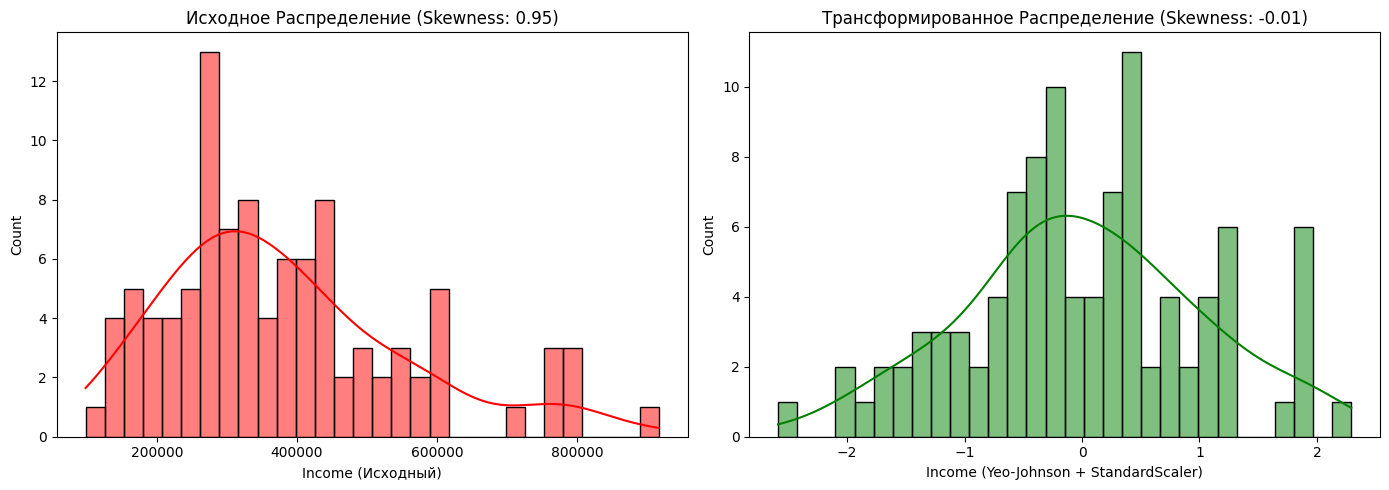

In [8]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer

# --- 1. Генерация сильно скошенного признака с выбросом ---
np.random.seed(42)
# Логнормальное распределение (имитация дохода)
income = np.random.lognormal(mean=10.5, sigma=0.5, size=100) * 10
# Искусственный выброс
income[0] = 500_000 
df = pd.DataFrame({'Income': income})
data = df[['Income']]

print("--- 1. Сравнение масштабирования ---")

# Standard Scaler (ИСКАЖАЕТСЯ выбросом)
scaler_standard = StandardScaler()
df['Income_Standard'] = scaler_standard.fit_transform(data)

# MinMax Scaler (ИСКАЖАЕТСЯ выбросом, большинство данных сжимается к 0)
scaler_minmax = MinMaxScaler()
df['Income_MinMax'] = scaler_minmax.fit_transform(data)

# Robust Scaler (УСТОЙЧИВ к выбросу, сохраняет структуру основного ядра данных)
scaler_robust = RobustScaler()
df['Income_Robust'] = scaler_robust.fit_transform(data)

print(df[['Income', 'Income_Standard', 'Income_MinMax', 'Income_Robust']].head())


print("\n--- 2. Трансформация Yeo-Johnson ---")

# Yeo-Johnson для снижения асимметрии
power_transformer = PowerTransformer(method='yeo-johnson')

# Трансформируем данные (теперь распределение ближе к нормальному)
df['Income_Transformed'] = power_transformer.fit_transform(data)

# После трансформации часто применяют Standard Scaler
scaler_final = StandardScaler()
df['Income_Final'] = scaler_final.fit_transform(df[['Income_Transformed']])

print(f"Skewness (Исходный): {df['Income'].skew():.2f}")
print(f"Skewness (Трансформированный): {df['Income_Final'].skew():.2f}")

print("--- Генерация графиков для визуальной проверки ---")

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 5))

# 1. Исходное распределение (сильно скошенное)
plt.subplot(1, 2, 1)
# Используем histplot с KDE для наглядности
sns.histplot(df['Income'], kde=True, bins=30, color='red')
plt.title(f"Исходное Распределение (Skewness: {df['Income'].skew():.2f})")
plt.xlabel("Income (Исходный)")

# 2. Трансформированное распределение (близкое к нормальному)
plt.subplot(1, 2, 2)
sns.histplot(df['Income_Final'], kde=True, bins=30, color='green')
plt.title(f"Трансформированное Распределение (Skewness: {df['Income_Final'].skew():.2f})")
plt.xlabel("Income (Yeo-Johnson + StandardScaler)")

plt.tight_layout()
plt.show()

# 1.2.3 Кодирование Категориальных Признаков (Categorical Encoding)

Кодирование преобразует нечисловые (текстовые) признаки в числовой формат, понятный алгоритмам машинного обучения.

---

### Основные Методы Кодирования

| Метод | Назначение | Плюсы | Минусы |
| :--- | :--- | :--- | :--- |
| **One-Hot Encoding (OHE)** | Номинальные признаки (без порядка). | Не вносит искажений и искусственных порядков. Идеален для линейных моделей. | Создает **много новых признаков** (проблема размерности) и разряженность матрицы (Sparse Matrix), особенно при высокой кардинальности. |
| **Label/Ordinal Encoding** | **Порядковые** признаки (есть иерархия, например, "Низкий", "Средний", "Высокий"). | Экономит память (один столбец). | Применяется только к порядковым данным. **Опасен** для номинальных данных, так как вносит искусственный, бессмысленный порядок. |
| **Target/Mean Encoding** | Номинальные признаки (особенно с высокой кардинальностью). | Сжимает высокий кардинальный признак в один столбец. Вносит информацию о целевой переменной. | **Высокий риск утечки данных (Data Leakage)**, если не используется сглаживание и перекрестная валидация. Обязательно применение только на трейне. |
| **Hashing Encoding** | Номинальные признаки с очень высокой кардинальностью. | Устраняет проблему высокой размерности OHE, фиксируя количество признаков. | Есть риск **коллизий** (разные категории могут получить один хеш). Потеря интерпретируемости. |

### Концепция Target Encoding и Защита от Утечки

**Target Encoding** заменяет каждую категорию на **среднее значение целевой переменной** для этой категории.

* **Риск:** Если категория содержит очень мало наблюдений, среднее будет нестабильным, и может произойти утечка данных.
* **Решение:** Использовать **кросс-валидацию** (K-Fold Target Encoding) или **сглаживание (Smoothing)**, чтобы значение кодировщика зависело не только от текущей категории, но и от глобального среднего.

In [12]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import StratifiedKFold
# Target Encoder обычно импортируется из catboost, category_encoders или реализуется вручную

df = pd.DataFrame({
    'Color': ['Red', 'Blue', 'Green', 'Red', 'Blue'],           # Номинальный
    'Size': ['Small', 'Medium', 'Large', 'Medium', 'Small'],    # Порядковый
    'Target': [0, 1, 0, 1, 0]                                   # Целевая переменная для Target Encoding
})


print("--- 1. One-Hot Encoding (OHE) ---")
# Используем drop='first' для избежания мультиколлинеарности
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')
color_ohe = ohe_encoder.fit_transform(df[['Color']])
ohe_df = pd.DataFrame(color_ohe, columns=ohe_encoder.get_feature_names_out(['Color']))
print("OHE (Color):")
print(ohe_df)


print("\n--- 2. Ordinal Encoding (Порядковый) ---")
# Обязательно задаем порядок вручную!
sizes = ['Small', 'Medium', 'Large']
ordinal_encoder = OrdinalEncoder(categories=[sizes])
df['Size_Encoded'] = ordinal_encoder.fit_transform(df[['Size']])
print("Ordinal Encoding (Size):")
print(df[['Size', 'Size_Encoded']])


print("\n--- 3. Target (Mean) Encoding с защитой от Data Leakage ---")

# Концептуальная реализация Target Encoding с Кросс-валидацией (для защиты от утечки)
df['Color_Target'] = np.nan # Создаем новый столбец для закодированных значений

kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

for train_index, val_index in kf.split(df, df['Target']):
    # 1. Считаем среднее целевой переменной ТОЛЬКО на тренировочных данных
    mean_target = df.iloc[train_index].groupby('Color')['Target'].mean()
    
    # 2. Применяем эти средние к валидационной выборке (val_index)
    df.loc[val_index, 'Color_Target'] = df.iloc[val_index]['Color'].map(mean_target)

# Замена оставшихся NaN (или категорий, не попавших в Train) на глобальное среднее
global_mean = df['Target'].mean()
df['Color_Target'] = df['Color_Target'].fillna(global_mean)

print("\nTarget Encoding (Color, с защитой):")
print(df[['Color', 'Target', 'Color_Target']])
# Обратите внимание: Цвет "Red" в разных строках может иметь разное Target значение, 
# так как оно рассчитано на разных фолдах (это защита от утечки).

--- 1. One-Hot Encoding (OHE) ---
OHE (Color):
   Color_Green  Color_Red
0          0.0        1.0
1          0.0        0.0
2          1.0        0.0
3          0.0        1.0
4          0.0        0.0

--- 2. Ordinal Encoding (Порядковый) ---
Ordinal Encoding (Size):
     Size  Size_Encoded
0   Small           0.0
1  Medium           1.0
2   Large           2.0
3  Medium           1.0
4   Small           0.0

--- 3. Target (Mean) Encoding с защитой от Data Leakage ---

Target Encoding (Color, с защитой):
   Color  Target  Color_Target
0    Red       0           0.4
1   Blue       1           0.4
2  Green       0           0.4
3    Red       1           0.4
4   Blue       0           0.4


# 1.2.4 Обработка Выбросов (Outlier Treatment)

Обработка выбросов направлена на **снижение их влияния** на метрики модели, а не на их полное удаление.

---

### Методы Обработки Выбросов

| Метод | Концепция | Назначение |
| :--- | :--- | :--- |
| **Удаление (Deletion)** | Удаление целой строки, содержащей выброс. | Используется только в случае, если выброс — это **ошибка ввода/измерения**, и общее количество выбросов составляет **менее 1-2%** данных. |
| **Винсоризация / Клиппинг (Winsorization / Clipping)** | **Ограничение (capping)** экстремальных значений. Выбросы заменяются на значение ближайшего перцентиля (например, 5-й и 95-й). | **IQR/Percentile Clipping** — самый распространенный и безопасный метод. Сохраняет наблюдения, но уменьшает их экстремальность. |
| **Трансформация (Transformation)** | Применение **логарифма**, **квадратного корня** или **степенных преобразований** (Box-Cox, Yeo-Johnson). | Эффективно **сжимает** распределения с длинными хвостами (Skewness), приближая их к нормальному. |
| **Использование Робастных Моделей** | Применение алгоритмов, которые по своей природе **устойчивы к выбросам**. | Избавляет от необходимости явной предобработки. Примеры: **RobustScaler** (вместо Standard), **Random Forest**, **Decision Trees** (на основе квартилей), **Huber Regressor**. |

---

### Практические Методы Клиппинга

#### 1. IQR-метод Клиппинга
* **Логика:** Значения, выходящие за пределы $[Q_1 - 1.5 \cdot IQR; Q_3 + 1.5 \cdot IQR]$, заменяются на граничные значения $Q_1 - 1.5 \cdot IQR$ или $Q_3 + 1.5 \cdot IQR$.

#### 2. Percentile Clipping
* **Логика:** Значения, выходящие за пределы $[p_{\alpha}; p_{100-\alpha}]$ (например, 5-й и 95-й перцентили), заменяются на сами эти перцентили.
* **Применение:** Более прост и часто используется на практике для **фиксации хвостов**.

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import iqr

# --- 1. Генерация данных с выбросом ---
np.random.seed(42)
income = np.random.lognormal(mean=10.5, sigma=0.5, size=100) * 10
# Искусственный выброс (Outlier)
income[0] = 500000 
df = pd.DataFrame({'Income_Raw': income})
data = df['Income_Raw']

print(f"Исходный Max Income: {data.max():.2f}")


# --- 2. Метод: IQR-Клиппинг ---
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
# Границы (1.5 * IQR)
lower_bound_iqr = Q1 - 1.5 * IQR
upper_bound_iqr = Q3 + 1.5 * IQR

# Клиппинг
df['Income_IQR_Clipped'] = data.clip(lower=lower_bound_iqr, upper=upper_bound_iqr)

print("\n--- 2.1. IQR-Клиппинг ---")
print(f"Граница клиппинга: {upper_bound_iqr:.2f}")
print(f"Max Income после IQR-клиппинга: {df['Income_IQR_Clipped'].max():.2f}")


# --- 3. Метод: Percentile Clipping (5% и 95%) ---
# Находим 5-й и 95-й перцентили
p5 = data.quantile(0.05)
p95 = data.quantile(0.95)

# Клиппинг
df['Income_P95_Clipped'] = data.clip(lower=p5, upper=p95)

print("\n--- 3.1. Percentile Clipping ---")
print(f"Граница клиппинга (95-й перцентиль): {p95:.2f}")
print(f"Max Income после P95-клиппинга: {df['Income_P95_Clipped'].max():.2f}")
# P95 клиппинг более мягкий и часто предпочтителен, так как 1.5*IQR может быть слишком агрессивным.

Исходный Max Income: 916872.94

--- 2.1. IQR-Клиппинг ---
Граница клиппинга: 711640.11
Max Income после IQR-клиппинга: 711640.11

--- 3.1. Percentile Clipping ---
Граница клиппинга (95-й перцентиль): 761216.19
Max Income после P95-клиппинга: 761216.19
